In [3]:
# ComplEx embeddings :

hidden_channels = 10
batch_size = 4096
epochs = 10
file_path = "/home/elliot/Desktop/StageM2/data/iric/little_iric.tsv"

# Losses tests :

n_negative_triplets_per_positive = 4 # Number of false negatives triples per positive triple in the dataset for losses tests.
url = "https://purl.obolibrary.org/obo/go/go-basic.json.gz" # Where should I look for GO ?


# Imports, install and mount

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# %pwd
# print("DRIVE MOUNTED")

In [5]:
# ! pip install cuda
# ! pip install torch_geometric
# ! pip install dgl
# ! pip install nxontology
# ! pip install tensordict

import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import dgl
import os
from torch.nn.functional import normalize
from tensordict.tensordict import TensorDict

from nxontology.imports import from_file
import tensorflow as tf


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.0) or chardet (5.2.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/elliot/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-16 09:36:28.711724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 09:36:28.711921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 09:36:29.043234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unabl

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # Tip : Use cpu for debugging
print(device)

cuda


# Preparing ComplEx embeddings

## TSV to pyg.Data

We want :
- x (tensorised and processed node attributes) (1 for now)
- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
- edge_attr (a tensor that indicate the type of each edge)
- y (edge labels - optional, can be defined as node labels if needed)

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [7]:
iric = pd.read_csv(file_path, delimiter='\t')
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: i for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: i for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)


print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}
print(mapping_to_entity)
print(mapping_to_relation)

,subject,predicate,object
0,GO:0000001,is_a,GO:0048311
1,GO:0000001,is_a,GO:0048308
2,GO:0000002,is_a,GO:0007005
3,GO:0000003,is_a,GO:0008150
4,GO:0000006,is_a,GO:0005385
...,...,...,...
9994,GO:0009920,is_a,GO:0000919
9995,GO:0009920,is_a,GO:1903047
9996,GO:0009921,is_a,GO:0098797
9997,GO:0009922,is_a,GO:0016747


,subject,predicate,object
0,3519,0,5440
1,3519,0,4196
2,444,0,1619
3,1732,0,1777
4,4858,0,390
...,...,...,...
9994,2329,0,1535
9995,2329,0,4440
9996,297,0,5218
9997,6583,0,8446


Minima in mappings :
subject : 0
predicate : 0
object : 2
{'GO:0005005': 0, 'GO:0003185': 1, 'GO:0140677': 2, 'GO:0031669': 3, 'GO:0009501': 4, 'GO:0031312': 5, 'GO:0006598': 6, 'GO:0001828': 7, 'GO:0045014': 8, 'GO:0048592': 9, 'GO:0005343': 10, 'GO:0002784': 11, 'GO:0002319': 12, 'GO:0009529': 13, 'GO:0032091': 14, 'GO:0048565': 15, 'GO:0008467': 16, 'GO:0031410': 17, 'GO:0018271': 18, 'GO:0009398': 19, 'GO:0008839': 20, 'GO:0015171': 21, 'GO:0008200': 22, 'GO:0003328': 23, 'GO:0006018': 24, 'GO:0006844': 25, 'GO:0008671': 26, 'GO:0004644': 27, 'GO:0048511': 28, 'GO:0008687': 29, 'GO:0000090': 30, 'GO:0045930': 31, 'GO:0007288': 32, 'GO:0008154': 33, 'GO:0045953': 34, 'GO:0009863': 35, 'GO:0009537': 36, 'GO:0004063': 37, 'GO:0050817': 38, 'GO:0005811': 39, 'GO:0004807': 40, 'GO:0008502': 41, 'GO:0051702': 42, 'GO:0051647': 43, 'GO:0046447': 44, 'GO:0004361': 45, 'GO:0004831': 46, 'GO:0004655': 47, 'GO:0006683': 48, 'GO:0003011': 49, 'GO:0002128': 50, 'GO:0005581': 51, 'GO:0002173': 5

## Building init vars for Data :

In [8]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[3519, 3519,  444,  ...,  297, 6583, 7993],
        [5440, 4196, 1619,  ..., 5218, 8446, 4298]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Dataset looks valid ? 
 True


## Setting up datas and model


## Splitting dataset

In [9]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9000], edge_attr=[9000], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])
Number of edges in datasets : 
  Train: 8001

  Test : 1998

  Validation : 1998


 8859
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[7982, 5503,   96,  ..., 1377, 3783, 1013],
        [3327, 5018, 6029,  ..., 4525, 3917, 3597]], device='cuda:0'), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'), 'num_nodes': 8859, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'), 'edge_label_index': tensor([[7982, 

## Iniating model

In [10]:
model = ComplEx(
    num_nodes=train_data.num_nodes,
    # num_relations=train_data.num_edge_types,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
    # neg_sampling = 4
)

optimizer = optim.Adam(model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

## Training and testing ComplEx

In [11]:
@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train():
    model.train()
    total_loss = total_examples = 0

    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

In [12]:
torch.set_grad_enabled(True)
model.to(device)

model.reset_parameters()


start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

100%|██████████| 9000/9000 [00:27<00:00, 325.04it/s]


Start Test Mean Rank: 4406.99, Start Test MRR: 0.0011, Start Test Hits@10: 0.0010
Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6931
Epoch: 004, Loss: 0.6931
Epoch: 005, Loss: 0.6931
Epoch: 006, Loss: 0.6931
Epoch: 007, Loss: 0.6931
Epoch: 008, Loss: 0.6931
Epoch: 009, Loss: 0.6931


100%|██████████| 9000/9000 [00:26<00:00, 340.48it/s]

Start Test Mean Rank: 4406.99, Start Test MRR: 0.0011, Start Test Hits@10: 0.0010
Final Test Mean Rank: 1086.12, Final Test MRR: 0.0862, Final Test Hits@10: 0.1576


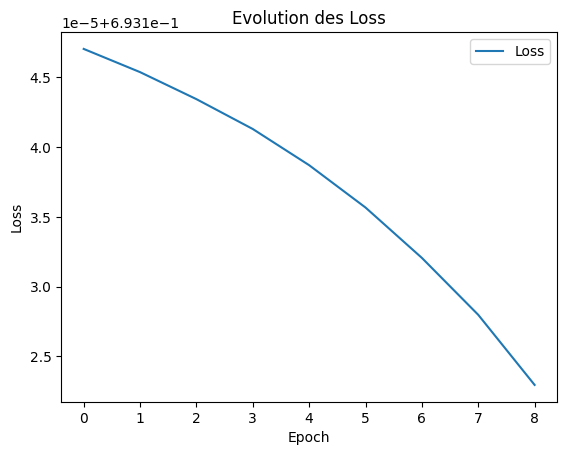

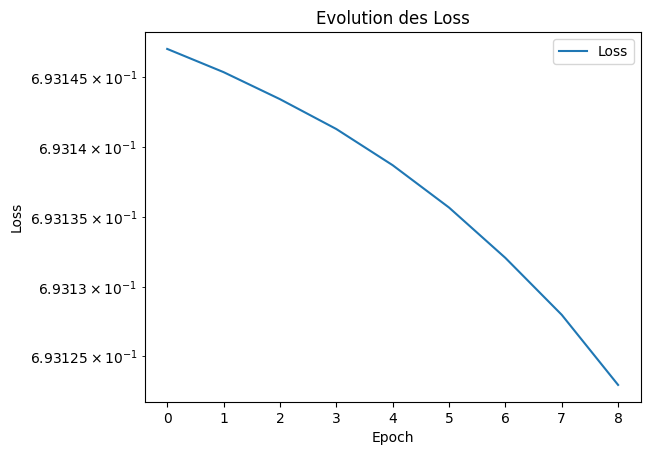

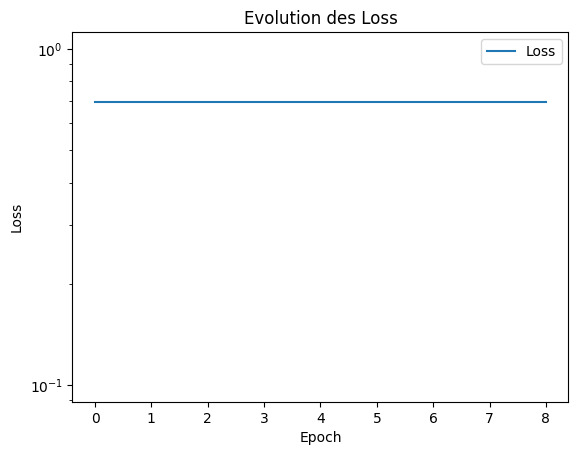

In [13]:
import matplotlib.pyplot as plt
def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider 
                                  # ahead and behind the pos X to calculate running mean at X.
                 ):

    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

plot_loss(losses)
plot_loss_log(losses)
plot_loss_log(running_mean(losses, 30))

## Making dict for association of embeddings and IDs (GO:XXXX)

In [14]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Desktop/StageM2/ESL2024/code/TestComplEx


In [15]:
entity_to_mapping

{'GO:0005005': 0,
 'GO:0003185': 1,
 'GO:0140677': 2,
 'GO:0031669': 3,
 'GO:0009501': 4,
 'GO:0031312': 5,
 'GO:0006598': 6,
 'GO:0001828': 7,
 'GO:0045014': 8,
 'GO:0048592': 9,
 'GO:0005343': 10,
 'GO:0002784': 11,
 'GO:0002319': 12,
 'GO:0009529': 13,
 'GO:0032091': 14,
 'GO:0048565': 15,
 'GO:0008467': 16,
 'GO:0031410': 17,
 'GO:0018271': 18,
 'GO:0009398': 19,
 'GO:0008839': 20,
 'GO:0015171': 21,
 'GO:0008200': 22,
 'GO:0003328': 23,
 'GO:0006018': 24,
 'GO:0006844': 25,
 'GO:0008671': 26,
 'GO:0004644': 27,
 'GO:0048511': 28,
 'GO:0008687': 29,
 'GO:0000090': 30,
 'GO:0045930': 31,
 'GO:0007288': 32,
 'GO:0008154': 33,
 'GO:0045953': 34,
 'GO:0009863': 35,
 'GO:0009537': 36,
 'GO:0004063': 37,
 'GO:0050817': 38,
 'GO:0005811': 39,
 'GO:0004807': 40,
 'GO:0008502': 41,
 'GO:0051702': 42,
 'GO:0051647': 43,
 'GO:0046447': 44,
 'GO:0004361': 45,
 'GO:0004831': 46,
 'GO:0004655': 47,
 'GO:0006683': 48,
 'GO:0003011': 49,
 'GO:0002128': 50,
 'GO:0005581': 51,
 'GO:0002173': 52,
 'G

In [16]:
model.to('cpu')
torch.set_grad_enabled(False)

# Is model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))

print("Bad scores should appear here :")
print(model(torch.tensor(3307),torch.tensor(0),torch.tensor(4788)))
print(model(torch.tensor(6207),torch.tensor(0),torch.tensor(4378)))

Good score should appear here :


tensor(0.0001)
Bad scores should appear here :
tensor(2.0367e-05)
tensor(-2.4593e-05)


Attributs pour accéder aux embeddings :

        head_re = self.node_emb(head_index)
        head_im = self.node_emb_im(head_index)
        rel_re = self.rel_emb(rel_type)
        rel_im = self.rel_emb_im(rel_type)
        tail_re = self.node_emb(tail_index)
        tail_im = self.node_emb_im(tail_index)

In [17]:
# Extracting embeddings for each entity and relation in dicts.

entities_mapping_to_embedding = {}
relation_mapping_to_embedding = {}

for entity in entity_set:
    entity_id = entity_to_mapping[entity]

    real_part = model.node_emb(torch.tensor(entity_id))
    im_part = model.node_emb_im(torch.tensor(entity_id))

    embedding = torch.cat((real_part, im_part))

    entities_mapping_to_embedding[entity_id] = embedding

for relation in relation_set:
    relation_id = relation_to_mapping[relation]

    real_part = model.rel_emb(torch.tensor(relation_id))
    im_part = model.rel_emb_im(torch.tensor(relation_id))

    embedding = torch.cat((real_part, im_part))

    relation_mapping_to_embedding[relation_id] = embedding

In [18]:
relation_mapping_to_embedding

{0: tensor([ 0.0430, -0.0302, -0.0263,  0.0282, -0.0417, -0.0357,  0.0391,  0.0396,
         -0.0383, -0.0344,  0.0043, -0.0360,  0.0305, -0.0205,  0.0418, -0.0104,
         -0.0119,  0.0173, -0.0092,  0.0115])}

In [19]:
# Making the reverse dicts :

entities_embedding_to_mapping ={v: k for k, v in entities_mapping_to_embedding.items()}
relation_embedding_to_mapping = {v: k for k, v in relation_mapping_to_embedding.items()}

# Quick check :

def get_key_value_pair(input_dict, i = 0):
    key = list(input_dict.keys())[i]
    value = input_dict[key]
    return key, value
K = get_key_value_pair(entities_mapping_to_embedding)[0]
V = get_key_value_pair(entities_mapping_to_embedding)[1]
print(f"First key-value pear in entities_mapping_to_embedding :\nKey={K}\nValue={V}")
print(f"And the pair in the symmetric dictentities_embedding_to_mapping :\nKey={V}\nValue={entities_embedding_to_mapping[V]} ")

First key-value pear in entities_mapping_to_embedding :
Key=0
Value=tensor([ 0.0142, -0.0262, -0.0052,  0.0127,  0.0207,  0.0285, -0.0156, -0.0114,
         0.0161, -0.0161,  0.0233, -0.0126, -0.0264,  0.0244, -0.0140,  0.0249,
        -0.0016,  0.0021, -0.0162,  0.0088])
And the pair in the symmetric dictentities_embedding_to_mapping :
Key=tensor([ 0.0142, -0.0262, -0.0052,  0.0127,  0.0207,  0.0285, -0.0156, -0.0114,
         0.0161, -0.0161,  0.0233, -0.0126, -0.0264,  0.0244, -0.0140,  0.0249,
        -0.0016,  0.0021, -0.0162,  0.0088])
Value=0 


In [20]:
relation_embedding_to_mapping 

{tensor([ 0.0430, -0.0302, -0.0263,  0.0282, -0.0417, -0.0357,  0.0391,  0.0396,
         -0.0383, -0.0344,  0.0043, -0.0360,  0.0305, -0.0205,  0.0418, -0.0104,
         -0.0119,  0.0173, -0.0092,  0.0115]): 0}

In [21]:
# Making {embedding : 'GOXXXX'} dicts and their symmetrics, {'GOXXXX': embedding} for both entities and relations.

entity_embedding_to_ID=dict()
for ID in entity_to_mapping.keys():
    map = entity_to_mapping[ID]
    embed = entities_mapping_to_embedding[map]
    entity_embedding_to_ID[embed]=ID

entities_embedding_to_name = {v: k for k,v in entity_embedding_to_ID.items()}

relation_embedding_to_ID=dict()
for ID in relation_to_mapping.keys():
    map = relation_to_mapping[ID]
    embed = relation_mapping_to_embedding[map]
    relation_embedding_to_ID[embed]=ID

entities_embedding_to_name = {v: k for k,v in relation_embedding_to_ID.items()}

In [22]:
print(relation_embedding_to_mapping) 
print(entities_embedding_to_name)

{tensor([ 0.0430, -0.0302, -0.0263,  0.0282, -0.0417, -0.0357,  0.0391,  0.0396,
        -0.0383, -0.0344,  0.0043, -0.0360,  0.0305, -0.0205,  0.0418, -0.0104,
        -0.0119,  0.0173, -0.0092,  0.0115]): 0}
{'is_a': tensor([ 0.0430, -0.0302, -0.0263,  0.0282, -0.0417, -0.0357,  0.0391,  0.0396,
        -0.0383, -0.0344,  0.0043, -0.0360,  0.0305, -0.0205,  0.0418, -0.0104,
        -0.0119,  0.0173, -0.0092,  0.0115])}


## Making dict of possibles tails for (head, relation) couples

In [23]:
possibles_tails: dict = {}
for index, row in iric.iterrows():
    head, rel, tail = row.iloc[0], row.iloc[1], row.iloc[2]
    hr = (head, rel)
    if hr not in possibles_tails:
        possibles_tails[hr]=[tail]
    else :
        possibles_tails[hr].append(tail)

print(possibles_tails)
    

{('GO:0000001', 'is_a'): ['GO:0048311', 'GO:0048308'], ('GO:0000002', 'is_a'): ['GO:0007005'], ('GO:0000003', 'is_a'): ['GO:0008150'], ('GO:0000006', 'is_a'): ['GO:0005385'], ('GO:0000007', 'is_a'): ['GO:0005385'], ('GO:0000009', 'is_a'): ['GO:0000030'], ('GO:0000010', 'is_a'): ['GO:0004659'], ('GO:0000011', 'is_a'): ['GO:0048308', 'GO:0007033'], ('GO:0000012', 'is_a'): ['GO:0006281'], ('GO:0000014', 'is_a'): ['GO:0004520'], ('GO:0000015', 'is_a'): ['GO:1902494'], ('GO:0000016', 'is_a'): ['GO:0004553'], ('GO:0000017', 'is_a'): ['GO:0042946'], ('GO:0000018', 'is_a'): ['GO:0051052'], ('GO:0000019', 'is_a'): ['GO:0000018'], ('GO:0000022', 'is_a'): ['GO:0051231', 'GO:1903047'], ('GO:0000023', 'is_a'): ['GO:0005984'], ('GO:0000024', 'is_a'): ['GO:0046351', 'GO:0000023'], ('GO:0000025', 'is_a'): ['GO:0000023', 'GO:0046352'], ('GO:0000026', 'is_a'): ['GO:0000030'], ('GO:0000027', 'is_a'): ['GO:0022618'], ('GO:0000028', 'is_a'): ['GO:0022618'], ('GO:0000030', 'is_a'): ['GO:0016758'], ('GO:0000

# Preparing a dataset to investigate modified loss

## Making negative triples

On va créer n triplets négatifs par triplet positif.
Pour créer un triplet négatif à partir d'un triplet positif, on remplace la tête de ce dernier par une entité aléatoire.
Il y a une chance de créer des faux négatifs, mais comme chaque entité apparait moins d'une fois sur 1000 dans le jeu de données, cette probabilité reste faible.

In [24]:
# Nombre d'apparition de chaque entité dans iric :
# mapped_iric.hist(column="subject", bins = len(list(entity_set)))

In [25]:
# Adding negative triples to our dataset.
# This is a naive implementation, it could be accelerated.

import numpy as np
from tqdm import tqdm
import random

def generate_negative_triples(df, number_of_false_per_true, falsify_relation = False):

    negative_triples = []

    possible_heads = list(set(list(df.iloc[:,0])))
    possible_relations = list(set(list(df.iloc[:,1])))
    possible_tails = list(set(list(df.iloc[:,2])))

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Negative Triples"):
        for i in range(number_of_false_per_true):

            if falsify_relation :
                r = np.random.randint(2) 
            else :
                r = np.random.randint(3)

            if r == 0:
                random_head = random.choice(possible_heads)
                negative_triples.append([random_head, row[1], row[2]])

            elif r == 1:
                random_tail = random.choice(possible_tails)
                negative_triples.append([row[0], row[1], random_tail])

            elif r == 2:
                random_relation = random.choice(possible_relations)
                negative_triples.append([row[0], random_relation, row[2]])
                
    negative_triples_df = pd.DataFrame(negative_triples, columns=df.columns)
    return pd.DataFrame(negative_triples_df)


def generate_negative_triples_HEAD_ONLY(df, number_of_false_per_true, falsify_relation = False):

    original = df.copy()

    # Coppying n times the original DF in a DF named falses
    falses = df.copy()
    for i in range(number_of_false_per_true-1):
        falses = pd.concat([falses,original])

    # Shuffling heads column
    falses.iloc[:,2]=falses.iloc[:,2].sample(frac=1).values
    
    return falses

negatives_from_iric = generate_negative_triples_HEAD_ONLY(mapped_iric, n_negative_triplets_per_positive)

display(mapped_iric)
display(negatives_from_iric)

,subject,predicate,object
0,3519,0,5440
1,3519,0,4196
2,444,0,1619
3,1732,0,1777
4,4858,0,390
...,...,...,...
9994,2329,0,1535
9995,2329,0,4440
9996,297,0,5218
9997,6583,0,8446


,subject,predicate,object
0,3519,0,8567
1,3519,0,5009
2,444,0,643
3,1732,0,7055
4,4858,0,5350
...,...,...,...
9994,2329,0,1677
9995,2329,0,6824
9996,297,0,896
9997,6583,0,7175


In [26]:
print(negatives_from_iric.iloc[:,2])

0       8567
1       5009
2        643
3       7055
4       5350
        ... 
9994    1677
9995    6824
9996     896
9997    7175
9998    3419
Name: object, Length: 39996, dtype: int64


In [27]:
# Adding lables to our datas.
# 1 : the link exists ; 0 : the link do not exists.

labelled_mapped_iric = mapped_iric.copy()
labelled_mapped_iric['label']=1
labelled_negatives_from_iric = negatives_from_iric.copy()
labelled_negatives_from_iric['label']=0
mapped_iric_with_negatives = pd.concat([labelled_mapped_iric, labelled_negatives_from_iric])
display(mapped_iric_with_negatives)

,subject,predicate,object,label
0,3519,0,5440,1
1,3519,0,4196,1
2,444,0,1619,1
3,1732,0,1777,1
4,4858,0,390,1
...,...,...,...,...
9994,2329,0,1677,0
9995,2329,0,6824,0
9996,297,0,896,0
9997,6583,0,7175,0


In [28]:
shuffled_mapped_iric_with_negatives = mapped_iric_with_negatives.sample(frac=1).reset_index(drop=True)
display(shuffled_mapped_iric_with_negatives)

,subject,predicate,object,label
0,7342,0,4836,1
1,177,0,7234,0
2,6292,0,6288,0
3,5664,0,5861,0
4,206,0,4463,0
...,...,...,...,...
49990,8146,0,3787,0
49991,5072,0,6390,0
49992,7998,0,2773,0
49993,2907,0,2302,0


## Mapped datas to embedded datas

In [29]:
display(shuffled_mapped_iric_with_negatives)

tensorized_triples = shuffled_mapped_iric_with_negatives.copy()
tensorized_triples['object'] = tensorized_triples['object'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['subject'] = tensorized_triples['subject'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['predicate'] = tensorized_triples['predicate'].apply(lambda x: relation_mapping_to_embedding[x])
display(tensorized_triples)

,subject,predicate,object,label
0,7342,0,4836,1
1,177,0,7234,0
2,6292,0,6288,0
3,5664,0,5861,0
4,206,0,4463,0
...,...,...,...,...
49990,8146,0,3787,0
49991,5072,0,6390,0
49992,7998,0,2773,0
49993,2907,0,2302,0


,subject,predicate,object,label
0,"[tensor(-0.0202), tensor(0.0043), tensor(0.022...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(-0.0129), tensor(0.0127), tensor(-0.02...",1
1,"[tensor(0.0127), tensor(0.0078), tensor(-0.024...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(0.0073), tensor(0.0104), tensor(-0.032...",0
2,"[tensor(-0.0182), tensor(0.0110), tensor(0.031...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(-0.0197), tensor(1.9971e-05), tensor(0...",0
3,"[tensor(-0.0052), tensor(0.0130), tensor(0.003...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(0.0061), tensor(0.0018), tensor(0.0125...",0
4,"[tensor(0.0090), tensor(0.0155), tensor(-0.002...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(-0.0265), tensor(0.0369), tensor(0.024...",0
...,...,...,...,...
49990,"[tensor(0.0150), tensor(-0.0110), tensor(0.019...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(0.0076), tensor(-0.0007), tensor(0.010...",0
49991,"[tensor(-0.0183), tensor(-0.0209), tensor(-0.0...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(0.0159), tensor(0.0164), tensor(0.0088...",0
49992,"[tensor(0.0156), tensor(-0.0059), tensor(-0.01...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(-0.0072), tensor(-0.0270), tensor(0.01...",0
49993,"[tensor(0.0015), tensor(-0.0181), tensor(0.008...","[tensor(0.0430), tensor(-0.0302), tensor(-0.02...","[tensor(0.0095), tensor(-0.0098), tensor(-0.00...",0


## Normalizing and merging triples

Contains a bug maker : here you can activate or unactivate normalization, which can create problems with Lin's similarity calculation.

In [30]:
# # Normalizing tensors.

# def normalize_tensor(x):
#     try :
#         return normalize(torch.tensor(x), dim=-1,eps=0.000001).clone().detach().requires_grad_(False)
#     except :
#         raise ValueError(f"Could not normalize this object : \n, {x}")

# normalized_tensorized_triples = tensorized_triples.copy()

# columns = tensorized_triples.columns[0:3]
# print(columns)

# tqdm.pandas(desc='Normalizing entities and relations')
# for column in columns:
#     normalized_tensorized_triples[column]=tensorized_triples[column].progress_apply(normalize_tensor)
#     # print(tensorized_triples.iloc[:i])

# display(normalized_tensorized_triples)

In [31]:
# Uncomment to cancel normalization.

normalized_tensorized_triples = tensorized_triples.copy()

In [32]:
tqdm.pandas(desc='Concataning embedded and normalized subjects, predicates and objects')
dataset = normalized_tensorized_triples.progress_apply(lambda row : pd.Series({'x': torch.cat([row.iloc[0], row.iloc[1], row.iloc[2]]), 'y': row.iloc[3]}), axis=1)
display(dataset)

Concataning embedded and normalized subjects, predicates and objects:   0%|          | 0/49995 [00:00<?, ?it/s]

Concataning embedded and normalized subjects, predicates and objects: 100%|██████████| 49995/49995 [00:13<00:00, 3742.04it/s]


,x,y
0,"[tensor(-0.0202), tensor(0.0043), tensor(0.022...",1
1,"[tensor(0.0127), tensor(0.0078), tensor(-0.024...",0
2,"[tensor(-0.0182), tensor(0.0110), tensor(0.031...",0
3,"[tensor(-0.0052), tensor(0.0130), tensor(0.003...",0
4,"[tensor(0.0090), tensor(0.0155), tensor(-0.002...",0
...,...,...
49990,"[tensor(0.0150), tensor(-0.0110), tensor(0.019...",0
49991,"[tensor(-0.0183), tensor(-0.0209), tensor(-0.0...",0
49992,"[tensor(0.0156), tensor(-0.0059), tensor(-0.01...",0
49993,"[tensor(0.0015), tensor(-0.0181), tensor(0.008...",0


In [33]:
first_subject = normalized_tensorized_triples['subject'][0]
first_predicate = normalized_tensorized_triples['predicate'][0]
first_object = normalized_tensorized_triples['object'][0]
first_triple = dataset['x'][0]
first_object_in_dataset = first_triple[0:hidden_channels*2]

print(first_object_in_dataset.equal(first_subject))

True


## Split dataset

In [34]:
import pandas as pd

def split_data(dataset, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1):

    total_samples = len(dataset)
    train_size = int(total_samples * train_ratio)
    test_size = int(total_samples * test_ratio)
    
    train_data = dataset[:train_size]
    test_data = dataset[train_size:train_size+test_size]
    val_data = dataset[train_size+test_size:]
    
    return train_data, test_data, val_data

train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

train, test, val = split_data(dataset, train_ratio, test_ratio, val_ratio)

display(train, val, test)

,x,y
0,"[tensor(-0.0202), tensor(0.0043), tensor(0.022...",1
1,"[tensor(0.0127), tensor(0.0078), tensor(-0.024...",0
2,"[tensor(-0.0182), tensor(0.0110), tensor(0.031...",0
3,"[tensor(-0.0052), tensor(0.0130), tensor(0.003...",0
4,"[tensor(0.0090), tensor(0.0155), tensor(-0.002...",0
...,...,...
34991,"[tensor(0.0113), tensor(-0.0120), tensor(0.023...",0
34992,"[tensor(-0.0237), tensor(0.0117), tensor(0.014...",0
34993,"[tensor(-0.0249), tensor(0.0292), tensor(-0.00...",1
34994,"[tensor(-0.0087), tensor(0.0089), tensor(0.009...",0


,x,y
44995,"[tensor(-0.0152), tensor(0.0261), tensor(0.019...",0
44996,"[tensor(-0.0288), tensor(0.0277), tensor(0.012...",0
44997,"[tensor(0.0271), tensor(-0.0016), tensor(0.031...",0
44998,"[tensor(0.0203), tensor(0.0068), tensor(0.0154...",1
44999,"[tensor(0.0043), tensor(-0.0271), tensor(-0.02...",0
...,...,...
49990,"[tensor(0.0150), tensor(-0.0110), tensor(0.019...",0
49991,"[tensor(-0.0183), tensor(-0.0209), tensor(-0.0...",0
49992,"[tensor(0.0156), tensor(-0.0059), tensor(-0.01...",0
49993,"[tensor(0.0015), tensor(-0.0181), tensor(0.008...",0


,x,y
34996,"[tensor(0.0051), tensor(-0.0256), tensor(0.007...",0
34997,"[tensor(-0.0064), tensor(0.0277), tensor(0.022...",0
34998,"[tensor(-0.0236), tensor(-0.0081), tensor(0.01...",0
34999,"[tensor(0.0021), tensor(-0.0216), tensor(-0.00...",0
35000,"[tensor(0.0146), tensor(-0.0300), tensor(0.010...",0
...,...,...
44990,"[tensor(-0.0148), tensor(-0.0258), tensor(-0.0...",0
44991,"[tensor(-0.0184), tensor(0.0306), tensor(0.004...",1
44992,"[tensor(0.0021), tensor(0.0010), tensor(-0.021...",0
44993,"[tensor(0.0126), tensor(-0.0119), tensor(-0.00...",0


# Testing loss difference

## Defining models

Here we define 3 models :
- untrained(), that we never train.
- classic(), that we train with a standard loss
- special(), that we train with a loss including Lin's similarity


In [35]:
print(dataset['x'][0].size()[0] == 6*hidden_channels)

True


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Créer le MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

input_size = 6 * hidden_channels  
hidden_size = 128  
output_size = 1     

untrained, classic, special = MLP(input_size, hidden_size, output_size), MLP(input_size, hidden_size, output_size), MLP(input_size, hidden_size, output_size)

## Defining losses

### Adapting embeddings-IDs dicts

In [37]:
def first_KV_pair(input:dict):
    '''
    return the first key-value pair of a given dict.
    '''
    key = next(iter(input))
    value = input[key]
    return key, value

def reverse_dict(input:dict):
    '''
    Inverse keys and values in a dict.
    Parameters :
    - A dict {K1:V1, K2:V2 ... Kn,Vn}.
    Returns :
    - A dict {V1:K1, V2:K2 ... Vn,Kn}.
    '''
    return {v:k for k, v in input.items()}

def last_times_first(input_tensor):
    '''
    Returns the product of the last element of the input tensor by the first element of the input tensor.
    Parameters :
    -
    Returns :
    - 

    '''
    return input_tensor[input_tensor.shape[0]-1].item()*input_tensor[0].item()

def tensor_element_to_product_element(input:dict, t:int=3):
    '''
    Replace all tensors of a dict by the product of their first and last element.
    Parameters :
    -
    Returns :
    - 
    '''
    before = len(input)
    try:
        if isinstance(first_KV_pair(input)[0], torch.Tensor):
            output = {last_times_first(key) : value for key, value in input.items()}
            print(f"size unchanged : {before==len(output)}")
            return output
        
        if isinstance(first_KV_pair(input)[1], torch.Tensor):
            output = {key : last_times_first(value) for key, value in input.items()}
            
        print(f"Size unchanged : {before==len(output)}")
        return output
             
    except:
        print("tensor_element_to_product_element() failed !",f"\n First Key-Value pair of input dict :\n{first_KV_pair(input)}")
        print(f"Tests : {isinstance(first_KV_pair(input)[1], torch.Tensor)}")
        print(f"Tests : {isinstance(first_KV_pair(input)[0], torch.Tensor)}")
        output = None


product_entities_embedding_to_mapping:dict = tensor_element_to_product_element(entities_embedding_to_mapping)
product_relation_embedding_to_mapping:dict = tensor_element_to_product_element(relation_embedding_to_mapping)
product_entities_mapping_to_embedding:dict = tensor_element_to_product_element(entities_mapping_to_embedding)
product_relation_mapping_to_embedding:dict = tensor_element_to_product_element(relation_mapping_to_embedding)

size unchanged : True
size unchanged : True
Size unchanged : True
Size unchanged : True


In [38]:
entity_product_embedding_to_ID = {k:mapping_to_entity[v] for k, v in product_entities_embedding_to_mapping.items()}
relation_product_embedding_to_ID = {k:mapping_to_relation[v] for k, v in product_relation_embedding_to_mapping.items()}

first_KV_pair(entity_product_embedding_to_ID)

entity_ID_to_embedding_product = reverse_dict(entity_product_embedding_to_ID)
relation_ID_to_embedding_product = reverse_dict(relation_product_embedding_to_ID)

In [39]:
def ID_from_embedding(input_tensor,input_dict):
    return input_dict[last_times_first(input_tensor=input_tensor)]

In [40]:
# Associates the possible tails for a (head, relation) double, with head and tail represented as product of their embeddings.
possibles_tails_with_product_keys:dict = {(entity_ID_to_embedding_product[k[0]],relation_ID_to_embedding_product[k[1]]):v for k,v in possibles_tails.items()}

print(first_KV_pair(possibles_tails))
print(first_KV_pair(possibles_tails_with_product_keys))

(('GO:0000001', 'is_a'), ['GO:0048311', 'GO:0048308'])
((-0.0001444494676656992, 0.0004953063518421362), ['GO:0048311', 'GO:0048308'])


In [41]:
def split_embed_triple(embed_triple):
    with torch.no_grad():
        embed_size = embed_triple.size()[0]
        tes = int(embed_size/3)
        h = embed_triple[0:tes]
        r = embed_triple[tes: 2*tes]
        t = embed_triple[2*tes: 3*tes]
        return h, r, t

### Defining loss

We use ID_from_embedding() with entity_product_embedding_to_ID (dict) to get  ID of each tensor when calculating alternative loss.

In [43]:
nxo = from_file(url)
nxo.freeze()

In [64]:

def lin_similarity(term1:str, term2:str, ontology, error_return = -1):
  '''
  Returns the highier lin similarity of two entities of a list of given ontologies.
  /!\ If calculation is impossible (for example if one of the entities is in none of the ontologies), return 0.

  Parameters :
  - term1 (str): ID of the first entity as a string (example : "GO:0042552")
  - term2 (str): ID of the second entity as a string (example : "GO:0042552")
  - ontology (nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - error_return : The output of the function if lin similarity cannot be calculated. Default -1.

  Returns :
  - linsim (float): The Lin similarity of the two entities in the ontology.
                    It is a a number in [0;1].
                    linsim(A,B) close of 0 means A and B are distant in the ontology ;
                    lisnsim(A,B) close of 1 means A and B are close entities in the ontology.
  '''  
  try :
      return ontology.similarity(term1, term2).lin
  except :
      return error_return
  


def LinSim_errors_for_embed_triple(triple,
                                   ontology,
                                   possibles_tails_for_embed_head_rel_doubles:dict,
                                   entity_product_embedding_to_ID:dict,
                                   relation_product_embedding_to_ID:dict,
                                   error_return = 0):
  '''
  Given an embeddeded triple and an ontology, calculates the list of LinSim between the real head of the triple and the expected heads for the (head, relation) couple.

  Parameters :
  - triple (torch.Tensor): The concatenation of the embeddings of head, relation and tail.
  - ontology (list of nxontology.ontology.NXOntology objects) : An ontology loaded with nxontology.
  - possibles_tails_for_embed_head_rel_doubles (dict): a dict with KEYS : (last_times_first(head_embedding), last_times_first(relation_embedding))
                                                                   VALUES : The possibles tails for the head-tail couple in iric (ex :['GO:0005356', 'GO:0005356'])
  - entity_product_embedding_to_ID (dict): a dict with KEYS : last_times_first(head_embedding)
                                                       VALUES : The ID of an entity in the ontology (ex : 'GO:0005356')
  - relation_product_embedding_to_ID (dict): a dict with KEYS : last_times_first(relation_embedding)
                                                         VALUES : The ID of a relation (ex : 'is_a')
  - error_return : The output of the function if lin similarity cannot be calculated. Default -1.

  Returns :
  - similarities (list) : the list of LinSim between the actual triple head and the possible heads of the triple found in iric.
  '''
  with torch.no_grad():
    h_emb, r_emb, t_emb = split_embed_triple(triple)
    h_ID = ID_from_embedding(h_emb, entity_product_embedding_to_ID)
    r_ID = ID_from_embedding(r_emb, relation_product_embedding_to_ID)
    possibles_tails = possibles_tails_for_embed_head_rel_doubles[(last_times_first(h_emb),last_times_first(r_emb))]
    similarities = [lin_similarity(h_ID, tail, ontology=ontology, error_return=error_return) for tail in possibles_tails]
    
  return similarities


def lin_loss(batch,
             possibles_tails_for_embed_head_rel_doubles,
             entity_product_embedding_to_ID,
             relation_product_embedding_to_ID,
             ontology,
             error_return):
    
    sims = []
    for embed_triple in batch:
        sims.append(max(LinSim_errors_for_embed_triple(triple = embed_triple,
                                                       possibles_tails_for_embed_head_rel_doubles = possibles_tails_for_embed_head_rel_doubles,
                                                       entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                                                       relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                                                       ontology=ontology,
                                                       error_return=error_return)))
            
    return sims

t = dataset['x'][0]
ts =list(dataset['x'][0:3])
batchy = torch.from_numpy(np.array(ts))


LinSim_errors_for_embed_triple(triple=t,
                               possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo)




lin_loss(batch = batchy,
         possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
         entity_product_embedding_to_ID = entity_product_embedding_to_ID,
         relation_product_embedding_to_ID = relation_product_embedding_to_ID,
         ontology=nxo,
         error_return=0)
    


ts =list(dataset['x'][0:3])
batchy = torch.from_numpy(np.array(ts))


sims = []
for embed_triple in ts:
  sims.append(max(LinSim_errors_for_embed_triple(triple = embed_triple,
  possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                                    entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                                    relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                                    ontology=nxo,
                                    error_return=0)))
        
print(sims)

[0.9922805624922703, 0.9922805624922703, 0.9908379977045333]


[0.9922805624922703, 0.9922805624922703, 0.9908379977045333]

In [53]:
print(list(dataset['x'][0:3]))

[tensor([-2.0159e-02,  4.2681e-03,  2.2041e-02,  2.4551e-03,  6.7459e-03,
        -1.8024e-02, -7.4452e-03,  2.4492e-06,  1.1619e-02,  1.0509e-02,
         5.8421e-03, -2.7624e-02,  2.0956e-02, -8.6907e-03,  2.0154e-02,
        -1.6005e-02,  1.4525e-02, -1.8138e-02, -2.5628e-03, -1.6840e-02,
         4.2994e-02, -3.0208e-02, -2.6272e-02,  2.8227e-02, -4.1740e-02,
        -3.5733e-02,  3.9101e-02,  3.9579e-02, -3.8347e-02, -3.4414e-02,
         4.2990e-03, -3.6046e-02,  3.0467e-02, -2.0477e-02,  4.1794e-02,
        -1.0365e-02, -1.1879e-02,  1.7257e-02, -9.2021e-03,  1.1520e-02,
        -1.2925e-02,  1.2696e-02, -2.9118e-02, -1.6050e-02, -4.0189e-04,
        -7.0856e-03,  1.3530e-02,  6.0734e-04, -5.2785e-03,  2.9444e-02,
        -1.6515e-02,  1.3516e-02, -1.1731e-02,  2.0599e-02,  3.3296e-04,
        -1.5476e-02, -1.8948e-02,  2.5610e-02,  1.2489e-02, -4.8998e-03]), tensor([ 0.0127,  0.0078, -0.0244, -0.0231, -0.0101, -0.0015,  0.0175, -0.0180,
        -0.0329,  0.0255, -0.0167,  0.002

In [57]:

print(batchy)

for i in batchy:
    # print(i)
    print(LinSim_errors_for_embed_triple(triple = i,
                               possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo,
                               error_return=0))

batchy.size()[0]



tensor([[-2.0159e-02,  4.2681e-03,  2.2041e-02,  2.4551e-03,  6.7459e-03,
         -1.8024e-02, -7.4452e-03,  2.4492e-06,  1.1619e-02,  1.0509e-02,
          5.8421e-03, -2.7624e-02,  2.0956e-02, -8.6907e-03,  2.0154e-02,
         -1.6005e-02,  1.4525e-02, -1.8138e-02, -2.5628e-03, -1.6840e-02,
          4.2994e-02, -3.0208e-02, -2.6272e-02,  2.8227e-02, -4.1740e-02,
         -3.5733e-02,  3.9101e-02,  3.9579e-02, -3.8347e-02, -3.4414e-02,
          4.2990e-03, -3.6046e-02,  3.0467e-02, -2.0477e-02,  4.1794e-02,
         -1.0365e-02, -1.1879e-02,  1.7257e-02, -9.2021e-03,  1.1520e-02,
         -1.2925e-02,  1.2696e-02, -2.9118e-02, -1.6050e-02, -4.0189e-04,
         -7.0856e-03,  1.3530e-02,  6.0734e-04, -5.2785e-03,  2.9444e-02,
         -1.6515e-02,  1.3516e-02, -1.1731e-02,  2.0599e-02,  3.3296e-04,
         -1.5476e-02, -1.8948e-02,  2.5610e-02,  1.2489e-02, -4.8998e-03],
        [ 1.2657e-02,  7.8176e-03, -2.4440e-02, -2.3087e-02, -1.0142e-02,
         -1.5087e-03,  1.7496e-02, -1

3

In [46]:
    
    batchy = torch.from_numpy(np.array(ts))
    sims = []
    for embed_triple in np.nditer(batchy):
        sims.append(min(LinSim_errors_for_embed_triple(triple = embed_triple,
                                possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                                entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                                relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                                ontology=nxo,
                                error_return=0))

SyntaxError: incomplete input (3073059516.py, line 9)

In [ ]:

def 
    sims = []
    for embed_triple in batchy:
        # print(embed_triple)
        sims.append(max(LinSim_errors_for_embed_triple(triple = embed_triple,
                                    possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                                    entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                                    relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                                    ontology=nxo,
                                    error_return=0)))
        
    print(sims)

[0.9934556073280254, 0.8506702078842022, 0.9663595110764214]


In [ ]:
np.nditer(batchy, flags=['external_loop'], order='F')

In [ ]:
import torch

# Création du tenseur
tensor = torch.tensor([[1, 2, 3],
                       [4, 5, 6],
                       [7, 8, 9]])

# Itération sur chaque ligne du tenseur
for row in tensor:
    print(row)


tensor([1, 2, 3])
tensor([4, 5, 6])
tensor([7, 8, 9])


In [ ]:


for a in np.nditer(batchy, flags=['external_loop'], order='F'):
    print(a)
    split_embed_triple(a)
    # b = LinSim_errors_for_embed_triple(triple = a,
    #                            possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
    #                            entity_product_embedding_to_ID = entity_product_embedding_to_ID,
    #                            relation_product_embedding_to_ID = relation_product_embedding_to_ID,
    #                            ontology=nxo,
    #                            error_return=0)

NameError: name 'np' is not defined

In [ ]:
sims = []

for i in tf.unstack(batchy):
    print(type(i))
    


<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
import tensorflow as tf
x = tf.placeholder(tf.float32, shape=(None, 10))
x_unpacked = tf.unstack(x) # defaults to axis 0, returns a list of tensors

processed = [] # this will be the list of processed tensors
for t in x_unpacked:
    # do whatever
    result_tensor = t + 1
    processed.append(result_tensor)

output = tf.concat(processed, 0)

with tf.Session() as sess:
    print(sess.run([output], feed_dict={x: np.zeros((5, 10))}))

AttributeError: module 'tensorflow' has no attribute 'placeholder'

In [ ]:
def LinSim_errors_for_triples_tensor(
                                   tensor,
                                   ontology,
                                   possibles_tails_for_embed_head_rel_doubles:dict,
                                   entity_product_embedding_to_ID:dict,
                                   relation_product_embedding_to_ID:dict,
                                   error_return = 0
                                    ):
    
    sims = []
    for i in tf.unstack(tensor):
        sims.append(min(LinSim_errors_for_embed_triple(triple = tensor.item()[i]
                              ,possibles_tails_for_embed_head_rel_doubles = possibles_tails_for_embed_head_rel_doubles,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=ontology,
                               error_return=error_return))
        )
    
    return sims
    

LinSim_errors_for_triples_tensor(tensor = batchy[0,:]
                              ,possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo,
                               error_return=0)

2024-03-15 16:31:32.776330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 16:31:32.861178: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-15 16:31:32.861820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

RuntimeError: a Tensor with 60 elements cannot be converted to Scalar

In [ ]:
sims = torch.empty((0, 25), dtype=torch.float32,requires_grad=False)
sims[2]

IndexError: index 2 is out of bounds for dimension 0 with size 0

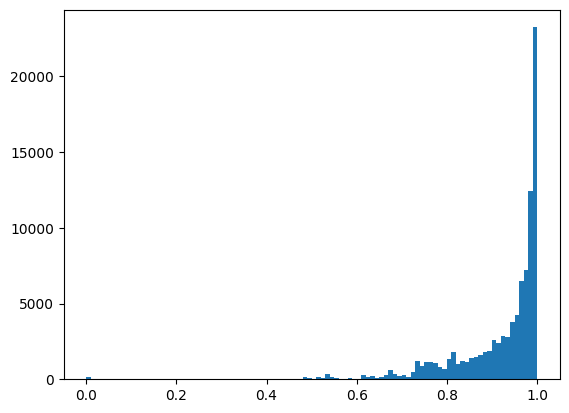

In [ ]:
sims = []
for i in range(len(dataset['x'])):
    t = dataset['x'][i]

    sims += LinSim_errors_for_embed_triple(triple=t,
                               possibles_tails_for_embed_head_rel_doubles = possibles_tails_with_product_keys,
                               entity_product_embedding_to_ID = entity_product_embedding_to_ID,
                               relation_product_embedding_to_ID = relation_product_embedding_to_ID,
                               ontology=nxo)

import matplotlib.pyplot as plt
plt.hist(sims, bins=100);

In [ ]:
first_KV_pair(entities_mapping_to_embedding)

(0,
 tensor([-0.0098, -0.0040,  0.0197, -0.0276, -0.0228, -0.0043,  0.0249, -0.0109,
         -0.0267, -0.0011,  0.0068, -0.0284, -0.0041, -0.0286, -0.0213,  0.0064,
          0.0238,  0.0210, -0.0111, -0.0020]))

In [ ]:
fh, fr, ft = iric_first_line

entity_ID_to_embedding = reverse_dict(entities_embedding_to_name)
relation_ID_to_embedding = reverse_dict(entities_embedding_to_name)
first_KV_pair(entities_embedding_to_name)
first_KV_pair(entity_ID_to_embedding)

# fhe, fte = entity_ID_to_embedding[fh], entity_ID_to_embedding[ft]

(tensor([ 0.0123,  0.0201, -0.0348,  0.0337,  0.0279, -0.0390, -0.0169, -0.0283,
         -0.0408, -0.0315, -0.0353, -0.0022,  0.0359,  0.0274,  0.0278, -0.0325,
         -0.0381,  0.0349, -0.0108,  0.0370]),
 'is_a')

In [ ]:
for i in range(0, len(dataset['x'])):
    t = dataset['x'][i]
    h_emb, r_emb, t_emb = split_embed_triple(t)
    h_ID = ID_from_embedding(h_emb, entity_product_embedding_to_ID)
    print(h_ID)

GO:0005360
GO:0003874
GO:0005125
GO:0001578
GO:0004507
GO:0009150
GO:0000209
GO:0009895
GO:0009059
GO:0009827
GO:0005858
GO:0009297
GO:0009158
GO:0002050
GO:0001068
GO:0004550
GO:0001829
GO:0009650
GO:0004455
GO:0000961
GO:0009534
GO:0005462
GO:0006571
GO:0000096
GO:0009326
GO:0008276
GO:0000304
GO:0004154
GO:0006173
GO:0009611
GO:0000514
GO:0009301
GO:0004090
GO:0008861
GO:0006552
GO:0009809
GO:0000827
GO:0000837
GO:0007063
GO:0003279
GO:0005130
GO:0009864
GO:0002494
GO:0007194
GO:0006486
GO:0007142
GO:0002104
GO:0007394
GO:0009835
GO:0002297
GO:0005579
GO:0007553
GO:0003249
GO:0003225
GO:0007275
GO:0002248
GO:0003427
GO:0002294
GO:0006967
GO:0000937
GO:0003412
GO:0001933
GO:0008384
GO:0006404
GO:0009085
GO:0001704
GO:0006239
GO:0002706
GO:0009584
GO:0009832
GO:0007318
GO:0005452
GO:0004825
GO:0001411
GO:0002046
GO:0004645
GO:0000252
GO:0002521
GO:0009333
GO:0008193
GO:0006677
GO:0006600
GO:0004970
GO:0009232
GO:0009204
GO:0008825
GO:0000437
GO:0009123
GO:0009184
GO:0009532
GO:0006567

## Training

In [ ]:
criterion = custom_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convertir les données en tenseurs PyTorch
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)


KeyError: 11714

## Test

KeyError: 0

# Depr

In [ ]:
entity_product_embedding_to_ID = {k:mapping_to_entity[v] for k, v in product_entities_embedding_to_mapping.items()}
get_key_value_pair(entity_product_embedding_to_ID)

In [ ]:
def check_dict_chain(dicts:list, number_of_tests: int = 1):
    '''
    Parameters :
    -
    Returns :
    - 
    '''
    lengths = [len(dict) for dict in dicts]

    print(f'All dicts have the same size : {lengths.count(lengths[0])==len(lengths)}.') # Checking efficiently that all dicts have the same size
    for i in range(number_of_tests):
        found_no_error = False
        initial_key = random.choice(list(dicts[0].keys()))
        key = initial_key
        keys:list = [initial_key]
        for dict in dicts:
            try:
                key=dict[key]
                keys.append(key)
            except:
                raise KeyError(f"problem with key : {key} with type : {type(key)}.\nKeys list : {keys}\nProblematic dict :\n{dict}")
        print(f"Final key is equal initial key : {key == initial_key}.\nPath : {keys}")


In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Définition de la taille des données
num_samples = 1000
input_size = 10
hidden_size = 20
output_size = 1
batch_size = 32

# Création de données simulées
X_train = torch.randn(num_samples, input_size)
y_train = torch.randint(0, 2, (num_samples, output_size)).float()  # Génération de labels binaires aléatoires

# Création de DataLoader pour gérer les batchs
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Définition du modèle
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = MLP(input_size, hidden_size, output_size)

# Définition de la fonction de perte et de l'optimiseur
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Boucle d'entraînement
num_epochs = 100
for epoch in range(num_epochs):
    # Entraînement du modèle
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        print(type(input), inputs.size())
        loss.backward()
        optimizer.step()


        print(f'Epoch [{epoch+1}/{num_epochs}]')

# Évaluation du modèle
model.eval()
with torch.no_grad():
  total_correct = 0
  total_samples = 0
  for inputs, targets in train_loader:
    outputs = model(inputs)
    predicted = (outputs > 0.5).float()
    total_correct += (predicted == targets).sum().item()
    total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    print(accuracy)

print("Entraînement terminé!")


<class 'method'> torch.Size([32, 10])


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn